In [11]:
# Code author: Yuan Gong
# Email: yuangong@mit.edu
# Institution: Massachusetts Institute of Technology
# Date: 04/26

# Data Author: Yuanchao Li
# Email: yuanchao.li@ed.ac.uk
# Institution: University of Edinburgh
# Date: 04/26

# ! pip install openai
# ! pip install matplotlib seaborn scikit-learn
# ! pip install tenacity

import csv
import json
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential,
)
import time
from openai import OpenAI

# use your openai key
key = 'sk-'

In [12]:
file_path = 'F:\SLT_2024\iemocap_script_allemo.json'

# Open the JSON file and load its contents into a Python dictionary
with open(file_path, 'r') as file:
    data = json.load(file)

session_dict = {}

for item in data:
    session_id = item['id'][:6]
    if session_id not in session_dict:
        session_dict[session_id] = []
    session_dict[session_id].append(item)

# list the session in the training data
print('session in the data')
print(list(session_dict.keys()))

# print a sample entry of the first session
first_session = session_dict[list(session_dict.keys())[0]]

# Print each key-value pair in the first dictionary
print('-------------\na sample entry:')
for key, value in first_session[0].items():
    print(f"{key}: {value}")

session in the data
['Ses01F', 'Ses01M', 'Ses02F', 'Ses02M', 'Ses03F', 'Ses03M', 'Ses04F', 'Ses04M', 'Ses05F', 'Ses05M']
-------------
a sample entry:
need_prediction: no
emotion: fru
id: Ses01F_script01_1_F000
speaker: Ses01_F
groundtruth: What's he going to say?
hubertlarge: what's he ging to say
w2v2100: what's he gen to say
w2v2960: what's he going to say
w2v2960large: what's he going to say
w2v2960largeself: what's he going to say
wavlmplus: whats he gon to say
whisperbase: What's he gonna say?
whisperlarge: What's he gonna say?
whispermedium: What's he gonna say?
whispersmall: What's he gonna say?
whispertiny: What's he gonna say?


In [13]:
client = OpenAI(api_key='sk-')
log = []


@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(10))
def gpt_request(**kwargs):
  return client.chat.completions.create(**kwargs)

# predict the emotion of a sentence considerating the conversation context, using gpt-3.5-turbo based on whisper-tiny transcription
def gpt_emotion_predictor(context, cur_input, number_of_contexts=3):
  """
  Predicts the emotional state of a speaker based on the current input sentence and the conversational context.

  Parameters:
  context (list of dict): A list of dictionaries, each representing a previous conversational turn. Each dictionary
                          should contain at least the keys 'speaker' and 'sentence' indicating who the speaker was
                          and what they said, respectively.
  cur_input (dict): A dictionary representing the current sentence to be analyzed. It should contain at least the keys
                    'speaker' and 'sentence', similar to the dictionaries in `context`.
  number_of_contexts (int, optional): The number of contextual entries to consider for emotion prediction. Defaults to 3. The more context, the more expensive.

  Returns:
  str: The predicted emotion for the current sentence, from a set of predefined emotions such as 'happy', 'sad',
        'neutral', or 'angry'.
  """

  emotion_code_dict = {'happy': 'hap', 'neutral': 'neu', 'angry': 'ang', 'sad': 'sad'}
  # for simplicity, we just use whisper-tiny's transcription, feel free to use any transcription we provide, and you can combine them
  background = 'Two speakers are talking. The conversation is:\n'
  context = '\n'.join(f"{item['speaker']}: {item['whispertiny']}" for item in context[-number_of_contexts:]) + '\n'
  cur_sentence = f"Now speaker {cur_input['speaker']} says: '{cur_input['whispertiny']}'. \n"
  task = f"Predict the emotion of the sentence '{cur_input['whispertiny']}' from the options [happy, sad, neutral, angry], consider the conversation context, do not explain, only output the label in [happy, sad, neutral, angry]."
  prompt = background + context + cur_sentence + task
  #print(prompt)
  chat_history = [{"role": "system", "content": "You are a speech emotion predictor."},
                  {"role": "user", "content": prompt}]
  response = gpt_request(
             model="gpt-3.5-turbo",
             messages=chat_history).choices[0].message.content.strip().lower()
  #print('Predicted emotion:', response)
  #print('----------')
  if response not in emotion_code_dict:
    # model may still output emotion that is not in our list, project to neutral
    # print('prediction not in the options ', response)
    pred_emotion = 'neu'
  else:
    pred_emotion = emotion_code_dict[response]
  log.append([prompt, response])
  return pred_emotion

In [17]:
# input an entire session (conversation), and return a sequence of predictions of each sentence (that requires a prediction)
def predict_session(session):
  num_sentence = len(session)
  # a sequence of ground truth and predicted emotions, only record sentences that need prediction (i.e., emotion falls in [hap, sad, neu, ang])
  emotion_ground_truth, emotion_prediction = [], []
  for i, cur_sentence in enumerate(session):
    need_pred = cur_sentence['need_prediction']
    # if an emotion prediction is required for this sentence
    if need_pred == 'yes':
      cur_label = cur_sentence['emotion']
      # context is all previous sentences in the conversation
      cur_context = session[0:i]
      # input both context and the current sentence to the emotion predictor
      try:
        # avoid send request too frequent
        time.sleep(0.1)
        cur_pred = gpt_emotion_predictor(cur_context, cur_sentence)
        emotion_ground_truth.append(cur_label)
        emotion_prediction.append(cur_pred)
      except:
        # if there is an error, fill a neutral to keep the output of same dimension
        print('openai api has an error.')
        emotion_ground_truth.append('neu')
        emotion_prediction.append('neu')
    # # sanity check with few samples
    # if i > 5:
    #   break
  return emotion_ground_truth, emotion_prediction

# predict for all sessions
all_ground_truth, all_pred = [], []
for session in session_dict:
  # predictions of each session
  print('session', session)
  emotion_ground_truth, emotion_prediction = predict_session(session_dict[session])
  print('# ground truth emotion', len(emotion_ground_truth), '# predicted emotion', len(emotion_prediction))
  # concatenae predictions of all sessions
  all_ground_truth += emotion_ground_truth
  all_pred += emotion_prediction

csv.writer(open('F:\\SLT_2024\\train1\\pred.csv', 'w', newline='')).writerow(all_pred)
csv.writer(open('F:\\SLT_2024\\train1\\truth.csv', 'w', newline='')).writerow(all_ground_truth)
json.dump(log, open('F:\\SLT_2024\\train1\\log.json', 'w'), indent=4)

session Ses01F
# ground truth emotion 259 # predicted emotion 259
session Ses01M
# ground truth emotion 295 # predicted emotion 295
session Ses02F
# ground truth emotion 254 # predicted emotion 254
session Ses02M
# ground truth emotion 239 # predicted emotion 239
session Ses03F
openai api has an error.
openai api has an error.
openai api has an error.
# ground truth emotion 273 # predicted emotion 273
session Ses03M
# ground truth emotion 250 # predicted emotion 250
session Ses04F
# ground truth emotion 240 # predicted emotion 240
session Ses04M
# ground truth emotion 257 # predicted emotion 257
session Ses05F
# ground truth emotion 241 # predicted emotion 241
session Ses05M
# ground truth emotion 269 # predicted emotion 269


Classification Report:
               precision    recall  f1-score   support

         neu       0.32      0.70      0.44       610
         sad       0.45      0.32      0.37       475
         hap       0.53      0.15      0.23       681
         ang       0.64      0.58      0.61       811

    accuracy                           0.45      2577
   macro avg       0.49      0.44      0.41      2577
weighted avg       0.50      0.45      0.43      2577

Unweighted Accuracy: 0.4458672875436554


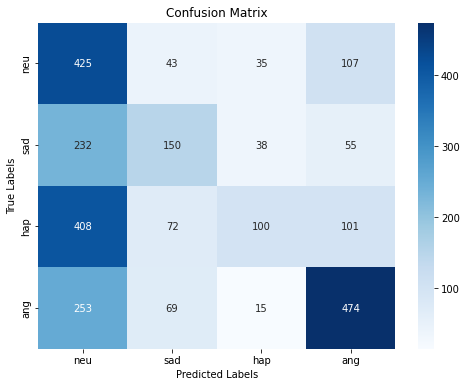

In [21]:
def evaluate_emotions(emotion_ground_truth, emotion_prediction):
    """
    Calculates the unweighted accuracy and plots the confusion matrix for given lists of ground truth and predicted emotions.

    Parameters:
    emotion_ground_truth (list of str): The list of true emotion labels.
    emotion_prediction (list of str): The list of predicted emotion labels.
    """
    class_report = classification_report(emotion_ground_truth, emotion_prediction, labels=['neu', 'sad', 'hap', 'ang'])
    print("Classification Report:\n", class_report)
    # Calculate unweighted accuracy
    accuracy = accuracy_score(emotion_ground_truth, emotion_prediction)
    print(f"Unweighted Accuracy: {accuracy}")

    # Generate confusion matrix
    conf_matrix = confusion_matrix(emotion_ground_truth, emotion_prediction, labels=['neu', 'sad', 'hap', 'ang'])

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['neu', 'sad', 'hap', 'ang'], yticklabels=['neu', 'sad', 'hap', 'ang'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

evaluate_emotions(all_ground_truth, all_pred)